### Generating 2D Drug Molecule Images from SMILES Using RDKit 
##### The images of drug molecules were generated from their SMILES representations utilizing the RDKit library

In [27]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F


# Set the base directory
base_dir = Path('Path_to_your_directory')


def load_dataset(dataset_name):
    
    data_path  = base_dir / "data"

    task_paths = {
    "biosnap_random": data_path / "biosnap/random",
    "human_random": data_path / "human/random",
    "human_cold": data_path / "human/cold"}
    

    dataset_path = task_paths[dataset_name]
   
    train_file = dataset_path / 'train.csv'
    valid_file = dataset_path / 'val.csv'
    test_file = dataset_path / 'test.csv'
 
    train = pd.read_csv(train_file)
    valid = pd.read_csv(valid_file)
    test = pd.read_csv(test_file)

    full_dataset = pd.concat([train, valid, test], ignore_index=True)

    return full_dataset

In [28]:
dataset_name = 'biosnap_random'
dataset= load_dataset(dataset_name)
unique_drugs = pd.DataFrame(dataset['SMILES'].unique(), columns=['SMILES']).reset_index(drop=True)
unique_drugs

,SMILES
0,OP(O)(=O)C(Cl)(Cl)P(O)(O)=O
1,NC1=NC(=O)N(C=N1)[C@H]1C[C@H](O)[C@@H](CO)O1
2,OCCCCCCCCNCO
3,C[C@H](OP(O)(O)=O)[C@@H](N)C(O)=O
4,CCO
...,...
4500,CCOC(=O)C1=CC2=CC=C(O)C=C2OC1=O
4501,[H][C@](O)(CN)CNC1=C2N=CC=CC2=C(C=C1)[N+]([O-])=O
4502,CC1NC2=CC(Cl)=C(C=C2C(=O)N1C1=CC=CC=C1C)S(N)(=...
4503,CCC1=NN(C2=C1C(=O)NC(CC1=CC(O)=C(O)C=C1)=N2)C1...


#### Display a 2D image of a molecule using RDKit from its SMILES string.

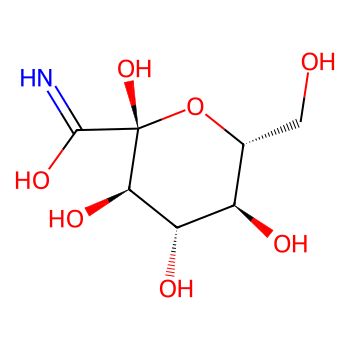

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display  

def draw_molecule_inline(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Invalid SMILES string")
        return

    # Generate 2D coordinates 
    Chem.rdDepictor.Compute2DCoords(mol)

    # Generate the 2D image 
    img = Draw.MolToImage(mol, kekulize=True, size=(350, 350))
    display(img)

smiles = unique_drugs['SMILES'][171] 
draw_molecule_inline(smiles)


In [7]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw


output_folder = base_dir / "images" / "mol_images"
output_folder.mkdir(parents=True, exist_ok=True)
 

def save_molecule_image(index, smiles, output_folder):
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    
    Chem.rdDepictor.Compute2DCoords(mol)
    
    image_path = os.path.join(output_folder, f"{index}.png")
    Draw.MolToFile(mol, image_path, kekulize=True, size=(256, 256))
   

for index, row in unique_drugs.iterrows():
    smiles = row["SMILES"]
    save_molecule_image(index, smiles, output_folder)

print(f"Molecule images have been saved.")

[00:38:05] Conflicting single bond directions around double bond at index 46.
[00:38:05]   BondStereo set to STEREONONE and single bond directions set to NONE.
[00:38:11] Unusual charge on atom 0 number of radical electrons set to zero


Molecule images have been saved.


### Protein Contact Maps Generation

In [4]:
unique_proteins = pd.DataFrame(dataset['Protein'].unique(), columns=['Protein']).reset_index(drop=True)
unique_proteins

,Protein
0,MGDHAWSFLKDFLAGGVAAAVSKTAVAPIERVKLLLQVQHASKQIS...
1,MVLDLDLFRVDKGGDPALIRETQEKRFKDPGLVDQLVKADSEWRRC...
2,MGNLKSVAQEPGPPCGLGLGLGLGLCGKQGPATPAPEPSRAPASLL...
3,MGNAAAAKKGSEQESVKEFLAKAKEDFLKKWESPAQNTAHLDQFER...
4,MVNENTRMYIPEENHQGSNYGSPRPAHANMNANAAAGLAPEHIPTP...
...,...
2176,MFSMRIVCLVLSVVGTAWTADSGEGDFLAEGGGVRGPRVVERHQSA...
2177,MAETVADTRRLITKPQNLNDAYGPPSNFLEIDVSNPQTVGVGRGRF...
2178,MAEGAAGREDPAPPDAAGGEDDPRVGPDAAGDCVTAASGGRMRDRR...
2179,MKMLTRLQVLTLALFSKGFLLSLGDHNFLRREIKIEGDLVLGGLFP...


In [12]:
import os
import torch
import esm
import matplotlib.pyplot as plt
import pandas as pd

out_folder = base_dir / "images" / "esm_contacts"
os.makedirs(out_folder, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ESM-2 model (esm2_t12_35M_UR50D)
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
model.eval()


data = [(str(idx), seq.strip()[:3000]) for idx, seq in unique_proteins["Protein"].items()]

batch_size = 1
for i in range(0, len(data), batch_size):
    batch_data = data[i:i + batch_size]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
    batch_tokens = batch_tokens.to(device)

    # Extract contacts
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[12], return_contacts=True)

    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

 
    for (label, seq), tokens_len, attention_contacts in zip(batch_data, batch_lens, results["contacts"]):
        attention_contacts = attention_contacts[:tokens_len, :tokens_len].cpu()  # Move to CPU for plotting
        fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=200)
        ax.matshow(attention_contacts, cmap='viridis')  
        ax.axis('off')  
        ax.set_facecolor('black') 
        fig.savefig(os.path.join(out_folder, f"{label}.png"), bbox_inches='tight', transparent=True)
        plt.close(fig) 

print(f"Contact maps saved.")


Using device: cuda
Contact maps saved.


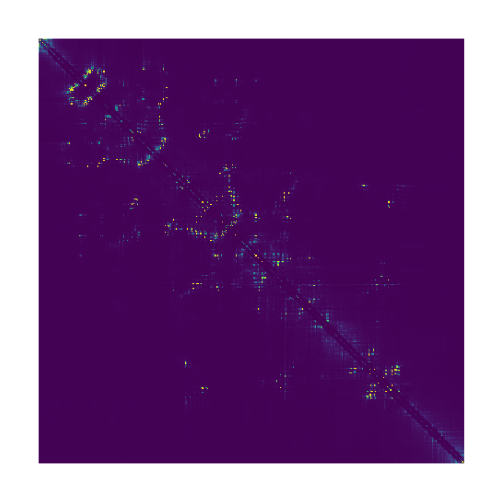

In [34]:
# Display a sample generated contact map
from PIL import Image
image_folder = base_dir / "images" / "esm_contacts"
image_path = os.path.join(image_folder, "103.png")

image = Image.open(image_path)
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
plt.imshow(image)
plt.axis('off')  
plt.show()